In [ ]:
import torch
from diffusers import DDPMScheduler, UNet1DModel
from fco2models.models import UNet2DModelWrapper
import json
import numpy as np

def load_model(save_dir, model_path, model_class):
    #read model hyperparameters
    with open(save_dir+'hyperparameters.json', 'r') as f:
        params = json.load(f)
    
    model_params = params['model_params']
    noise_params = params['noise_params']

    # load the model
    model = model_class(**model_params)
    model.load_state_dict(torch.load(save_dir+model_path))
    model.eval()
    noise_scheduler = DDPMScheduler(**noise_params)

    return model, noise_scheduler

# read validation data from npy file
val_ds = np.load('../data/training_data/val_ds.npy')
print(val_ds.shape)



unet1d, noise_scheduler = load_model('../models/unet_128_0.001/', 'sst_sss_chl_minmax.pt', UNet1DModel)
unet2d, noise_scheduler = load_model('../models/unet2d_64_0.0005/', 'e_20.pt', UNet2DModelWrapper)
# uncond_unet1d, noise_scheduler = load_model('../models/unconditional_128_0.001/', 'e_50.pt', UNet1DModel)



(8521, 4, 64)


# Denoise sample from given noise level

In [ ]:
def rec_sample(sample_context, model, noise_scheduler, timesteps):
    sample = torch.from_numpy(sample_context[0:1, :]).float()
    context = torch.from_numpy(sample_context[1:, :]).float()
    # add nan mask to the context
    nan_mask = ~torch.isnan(sample)
    context = torch.cat([context, nan_mask.float()], dim=0)

    nan_sample = torch.where(nan_mask, sample, torch.zeros_like(sample))
    # sample 100 times and plot the distribution of reconstructed fco2
    reconstructed_fco2s = []
    noisy_samples = []
    model.to('cpu')
    for _ in range(100):
        noise = torch.randn_like(nan_sample)
        noisy_sample = noise_scheduler.add_noise(nan_sample, noise, timesteps)
        input = torch.cat([noisy_sample, context], dim=0).unsqueeze(0)
        with torch.no_grad():
            output = model(input, timesteps)
    
        nan_fco2 = noise_scheduler.step(output[0], timesteps.item(), noisy_sample).pred_original_sample
        rec_fco2 = torch.where(nan_mask, nan_fco2, np.nan) # put in nans for better plotting
        reconstructed_fco2s.append(rec_fco2.numpy().flatten())
        # save noisy sample for plotting
        nan_noisy_sample = torch.where(nan_mask, noisy_sample, np.nan)
        noisy_samples.append(nan_noisy_sample.numpy().flatten())
    
    reconstructed_fco2s = np.array(reconstructed_fco2s)
    noisy_samples = np.array(noisy_samples)

    return reconstructed_fco2s, noisy_samples

def plot_rec(ax, recfco2s, noisy_samples, truth, title, plot_noisy=True):
    line01 = ax.plot(recfco2s.T[:,:10], color='blue', alpha=0.5)
    # plot devations from the mean
    ax.fill_between(np.arange(0, 64), recfco2s.mean(axis=0) - recfco2s.std(axis=0),
                     recfco2s.mean(axis=0) + recfco2s.std(axis=0), color='blue', alpha=0.5)
    if plot_noisy:
        # plot noisy samples
        line02 = ax.plot(noisy_samples.T[:,:10], color='green', alpha=0.5)
    ax.plot(recfco2s.mean(axis=0), label='reconstructed fco2', color='blue')
    ax.plot(truth.flatten(), label='true fco2', color='red')
    ax.legend(handles=[line01[0], line02[0]], labels=['reconstructed fco2', 'noisy sample'])
    ax.set_title(title)
    ax.set_xlabel('distance')
    ax.set_ylabel('fco2')
    return ax


8307
mean and std of the sample fco2: 0.312676481086728, 0.4187909455402603


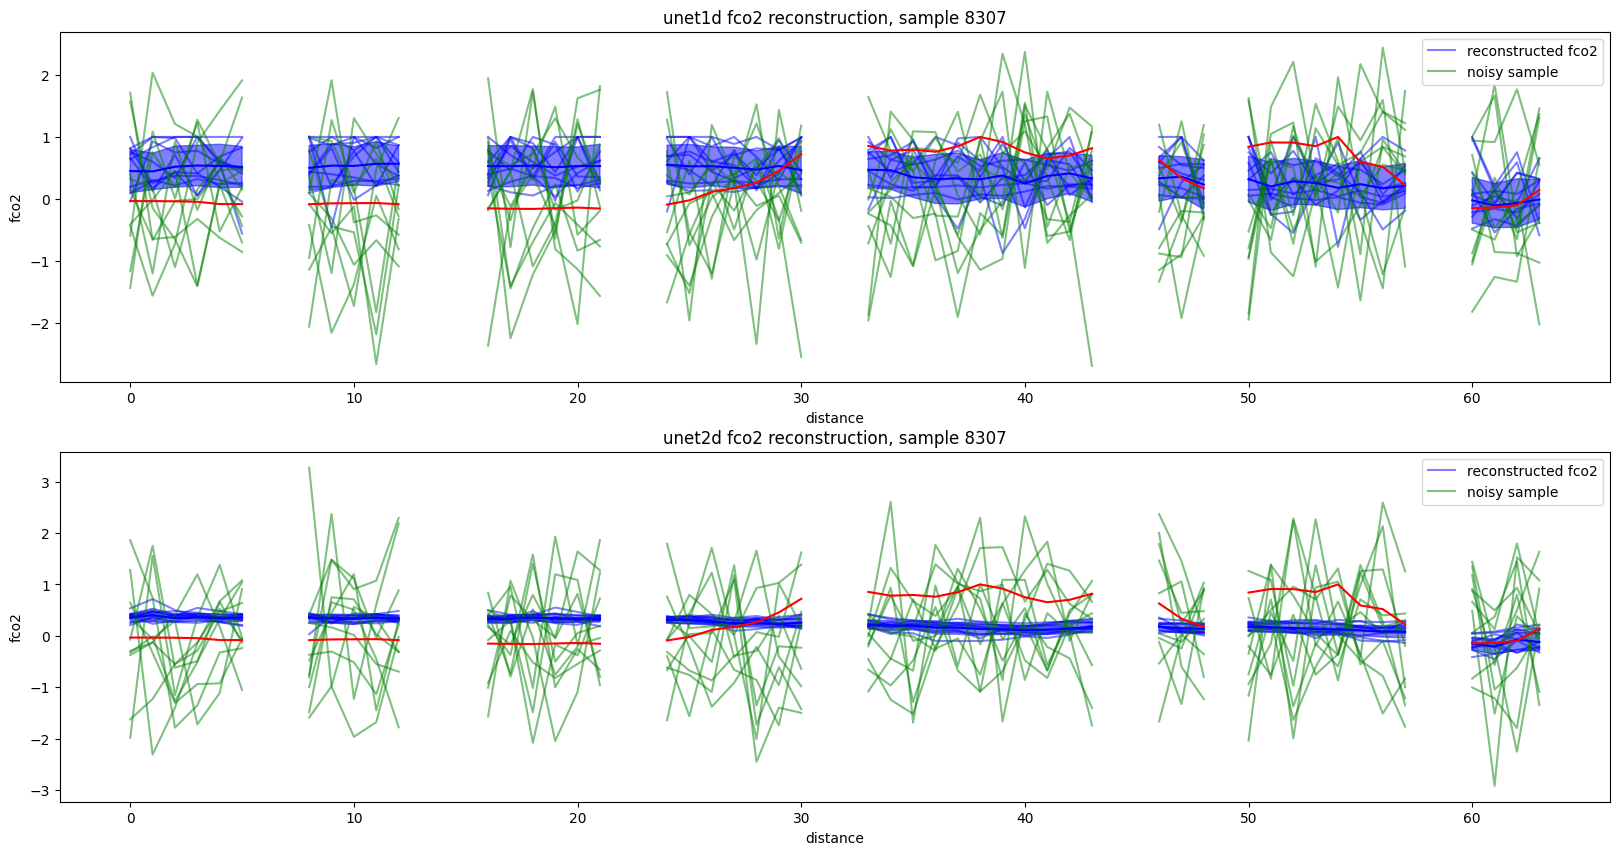

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# sort samples by largest std
ix = np.argsort(np.nanstd(val_ds[:, 0, :], axis=1))[::-1][1]
# ix = 1
print(ix)
print(f"mean and std of the sample fco2: {np.nanmean(val_ds[ix, 0:1, :])}, {np.nanstd(val_ds[ix, 0:1, :])}")

timesteps = torch.tensor(900)
unet1d_rec, noisy_samples1 = rec_sample(val_ds[ix], unet1d, noise_scheduler, timesteps)
unet2d_rec, noisy_samples2 = rec_sample(val_ds[ix], unet2d, noise_scheduler, timesteps)

n_models = 2
fig, axs = plt.subplots(n_models, 1, figsize=(20, n_models*5))
ax = plot_rec(axs[0], unet1d_rec, noisy_samples1, val_ds[ix, 0:1, :], f"unet1d fco2 reconstruction, sample {ix}")
ax = plot_rec(axs[1], unet2d_rec, noisy_samples2, val_ds[ix, 0:1, :], f"unet2d fco2 reconstruction, sample {ix}")

plt.show()

# Full denoising

In [ ]:
# ix = 4
fco2 = torch.from_numpy(val_ds[ix, 0:1, :]).float().view(1, 1, -1)
nan_sample = torch.where(torch.isnan(fco2), torch.zeros_like(fco2), fco2)
context = torch.from_numpy(val_ds[ix, 1:, :]).float().view(1, -1, 64)
print(context.shape)
print(sample.shape)

n_samples = 10
samples = []
for ix in range(n_samples):
    print(ix)
    # sample = noise_scheduler.add_noise(nan_sample, noise, torch.tensor(300))
    sample = noise_scheduler.add_noise(nan_sample, torch.randn_like(nan_sample), 999)
    for i, t in enumerate(noise_scheduler.timesteps):
        mask = torch.ones_like(sample).bool()
        # concat noise, context and mask
        sample_context = torch.cat([sample, context, mask], dim=1)
    
        # Get model pred
        with torch.no_grad():
            residual = model(sample_context, t, return_dict=False)[0]
    
        # Update sample with step
        sample = noise_scheduler.step(residual, t, sample).prev_sample
    samples.append(sample)

torch.Size([1, 3, 64])
torch.Size([1, 64])
0
1
2
3
4
5
6
7
8
9


C:\Users\henry\AppData\Local\Temp\ipykernel_2132\3389406437.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  picp(samples_arr, np.array(fco2.flatten()))


np.float64(0.921875)

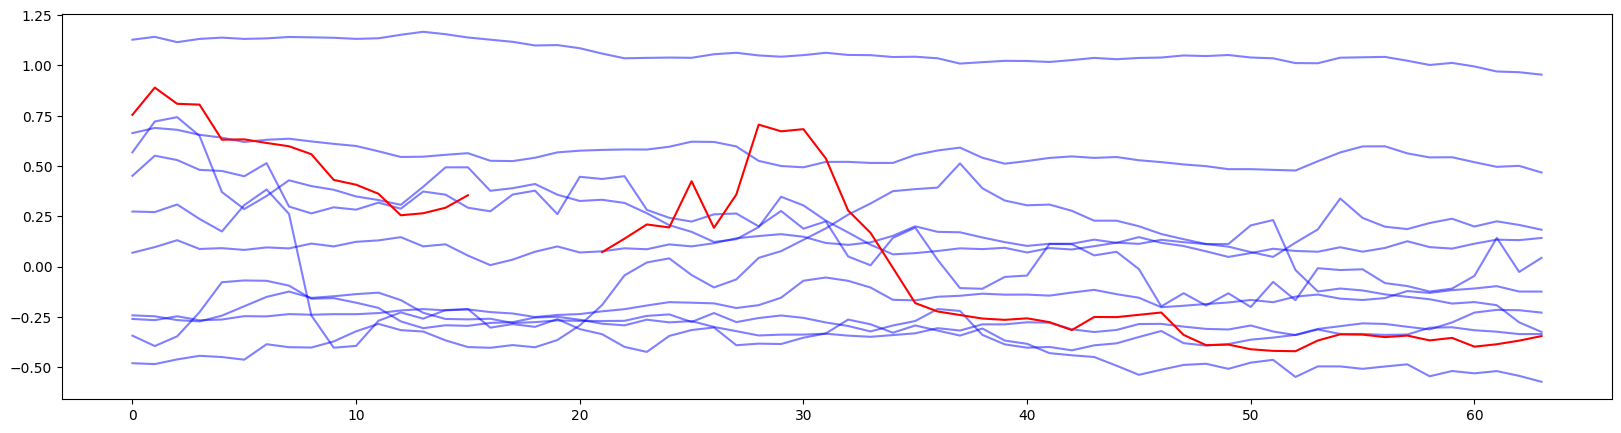

In [54]:
def picp(samples, fco2):
    y_hat_low = np.percentile(samples, 2.5, axis=0)
    y_hat_high = np.percentile(samples, 97.5, axis=0)

    return np.mean((y_hat_low < fco2) * (y_hat_high > fco2)) 

samples_arr = torch.cat(samples, dim=0)
samples_arr = samples_arr.squeeze(1).detach().numpy()
fig, axs = plt.subplots(1, 1, figsize=(20, 5))
axs.plot(samples_arr.T, color='blue', alpha=0.5)
axs.plot(fco2.flatten(), label='true fco2', color='red')
picp(samples_arr, np.array(fco2.flatten()))

# Jump denoising

In [66]:
fco2 = torch.from_numpy(val_ds[ix, 0:1, :]).float().view(1, 1, -1)
nan_sample = torch.where(torch.isnan(fco2), torch.zeros_like(fco2), fco2)
context = torch.from_numpy(val_ds[ix, 1:, :]).float().view(1, -1, 64)
print(context.shape)
print(sample.shape)

n_samples = 10
samples = []
for ix in range(n_samples):
    print(ix)
    # sample = noise_scheduler.add_noise(nan_sample, noise, torch.tensor(300))
    sample = noise_scheduler.add_noise(nan_sample, torch.randn_like(nan_sample), torch.tensor(999))
    jump = 10
    ts = noise_scheduler.timesteps[::jump]
    for _, t in enumerate(ts):
        mask = torch.ones_like(sample).bool()
        # concat noise, context and mask
        sample_context = torch.cat([sample, context, mask], dim=1)
    
        # Get model pred
        with torch.no_grad():
            residual = model(sample_context, t, return_dict=False)[0]
    
        # Update sample by jumping back in time
        x_0 = noise_scheduler.step(residual, t, sample).pred_original_sample
        if t > jump:
            sample = noise_scheduler.add_noise(x_0, torch.randn_like(sample), t - jump)
        else:
            sample = x_0
    # save the sample
    samples.append(sample)

torch.Size([1, 3, 64])
torch.Size([1, 1, 64])
0
1
2
3
4
5
6
7
8
9


C:\Users\henry\AppData\Local\Temp\ipykernel_2132\3389406437.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  picp(samples_arr, np.array(fco2.flatten()))


np.float64(0.921875)

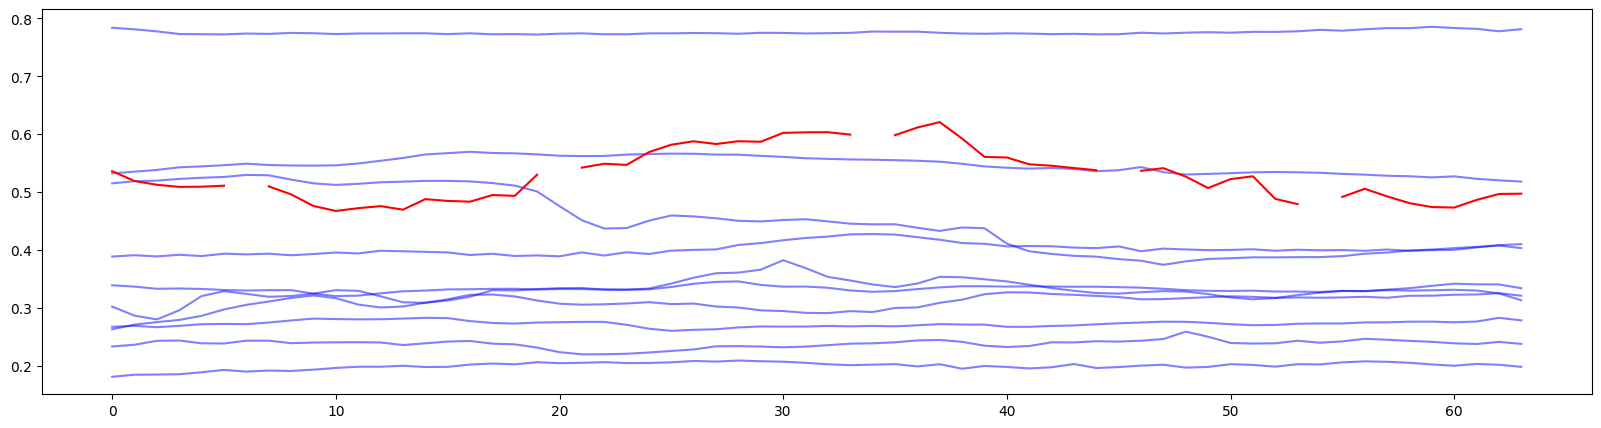

In [67]:
def picp(samples, fco2):
    y_hat_low = np.percentile(samples, 2.5, axis=0)
    y_hat_high = np.percentile(samples, 97.5, axis=0)

    return np.mean((y_hat_low < fco2) * (y_hat_high > fco2)) 

samples_arr = torch.cat(samples, dim=0)
samples_arr = samples_arr.squeeze(1).detach().numpy()
fig, axs = plt.subplots(1, 1, figsize=(20, 5))
axs.plot(samples_arr.T, color='blue', alpha=0.5)
axs.plot(fco2.flatten(), label='true fco2', color='red')
picp(samples_arr, np.array(fco2.flatten()))

# Predict collocated data  

In [1]:
import pandas as pd
df_collocated = pd.read_parquet('../data/inference/gridded_2022-10-04/collocated_data.pq')

In [2]:
df_collocated.head()

,lat,lon,block_index,time,chl_globcolour,chl_globcolour_uncert,chl_globcolour_flags,time_globcolour,lat_globcolour,lon_globcolour,...,lat_sss_multiobs,lon_sss_multiobs,depth_sss_multiobs,time_sss_multiobs,sst_cci,sst_cci_uncertainty,ice_cci,time_sst_cci,lat_sst_cci,lon_sst_cci
0,-89.975,0.000000,0,2022-10-04,NaN,NaN,1,2022-10-04,-89.979172,0.020839,...,-89.9375,0.0625,0.0,2022-10-04,NaN,NaN,NaN,2022-10-05,-89.974998,0.025000
1,-89.975,103.054526,0,2022-10-04,NaN,NaN,1,2022-10-04,-89.979172,103.062508,...,-89.9375,103.0625,0.0,2022-10-04,NaN,NaN,NaN,2022-10-05,-89.974998,103.074997
2,-89.975,206.109052,0,2022-10-04,NaN,NaN,1,2022-10-04,-89.979172,206.104172,...,-89.9375,206.0625,0.0,2022-10-04,NaN,NaN,NaN,2022-10-05,-89.974998,206.125000
3,-89.975,309.163577,0,2022-10-04,NaN,NaN,1,2022-10-04,-89.979172,309.145844,...,-89.9375,309.1875,0.0,2022-10-04,NaN,NaN,NaN,2022-10-05,-89.974998,309.174988
4,-89.925,0.000000,0,2022-10-04,NaN,NaN,1,2022-10-04,-89.937508,0.020839,...,-89.9375,0.0625,0.0,2022-10-04,NaN,NaN,NaN,2022-10-05,-89.925003,0.025000


In [ ]:
import numpy as np
df_inference = df_collocated[(df_collocated['lat'] > 10) & (df_collocated['lat'] < 15) & df_collocated['lon'] > 0]
# df_inference = df_inference[:400]
# print(df_inference.shape)
# print(df_inference.head())
cols = ['sst_cci', 'chl_globcolour', 'sss_cci', 'mld_dens_soda']

def segment_to_np(segment):
    # convert the segment to a numpy array
    values = np.zeros((1, 4, 64))
    n_values = segment.shape[0]
    values[0, :, :n_values] = segment[cols].values[:].T
    return values

inf_ds = df_inference.groupby(['lat', 'block_index']).apply(segment_to_np, include_groups=False)
inf_ds2 = np.vstack(inf_ds.values)
inf_ds2.shape

(12259, 4, 64)

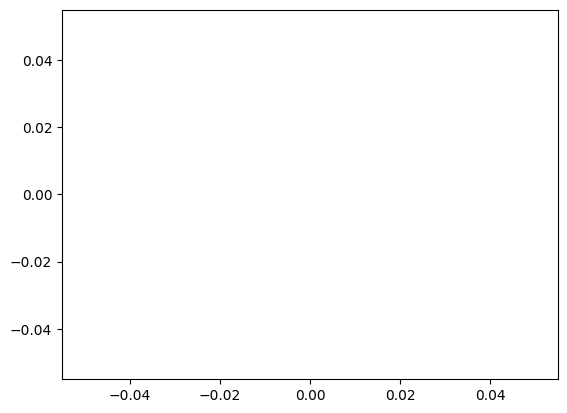

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(inf_ds2[0, 0, :], label='sst_cci')
# plt.plot(inf_ds2[0, 1, :], label='chl_globcolour')


In [8]:
from torch.utils.data import DataLoader
from fco2models.utraining import  full_denoise
from fco2models.models import  UNet2DModelWrapper
import json
from diffusers import DDPMScheduler, UNet1DModel
import torch
save_dir = '../models/unet/'
#read model hyperparameters
with open(save_dir+'hyperparameters.json', 'r') as f:
    params = json.load(f)

model_params = params['model_params']
noise_params = params['noise_params']

# read validation data from npy file
# val_ds = np.load('../data/training_data/val_ds.npy')
# load model

model = UNet1DModel(**model_params)
model.load_state_dict(torch.load(save_dir+'e_10.pt'))
model.eval()
noise_scheduler = DDPMScheduler(**noise_params)

train_means = params['train_means']
train_stds = params['train_stds']
inf_ds3 = np.zeros_like(inf_ds2)
for i in range(len(train_means[1:])):
    inf_ds3[:, i, :] = (inf_ds2[:, i, :] - train_means[i + 1]) / train_stds[i + 1]
print(np.nanmean(inf_ds3[:, 1, :]), np.nanstd(inf_ds3[:, 1, :]))
context = torch.from_numpy(inf_ds3).float()
context_loader = DataLoader(context, batch_size=2048, shuffle=False)

samples = full_denoise(model, noise_scheduler, context_loader, n_samples=2)

-4.452940310890139 0.1411450873430161
Training on cuda
0


Sample 1/2:  33%|███▎      | 2/6 [06:46<13:33, 203.28s/it, Batch=2]


KeyboardInterrupt: 

In [ ]:
samples.shape

(2, 7, 1, 64)

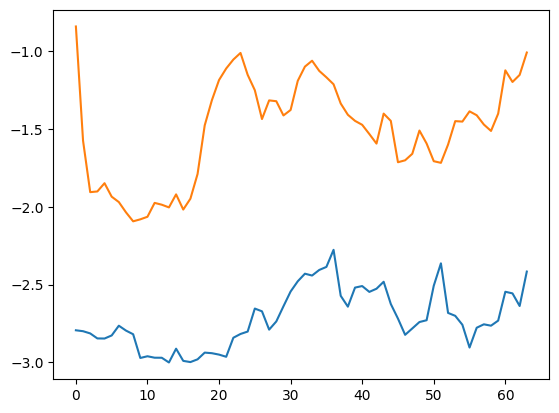

In [28]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(samples[0, 0, :].flatten(), label='fco21')
plt.plot(samples[1, 0, :].flatten(), label='fco22')
plt.show()